In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import StandardScaler, RobustScaler

In [2]:
reddit_df = pd.read_csv('10y_reddit_data.csv.zst')
yf_df = pd.read_csv('10y_stock_data.csv.zst')
print(reddit_df.head())
print(yf_df.head())
print(reddit_df.info())
print(yf_df.info())
print(reddit_df.columns)
print(yf_df.columns)

                   timestamp      id   created_utc         author  \
0  2015-12-05 00:00:00+00:00  3vk6qf  1.449337e+09  Johnny_Fratto   
1  2015-12-05 00:00:00+00:00  3vj1vg  1.449312e+09       formahyi   
2  2015-12-05 00:00:00+00:00  3vk6qf  1.449337e+09  Johnny_Fratto   
3  2015-12-06 00:00:00+00:00  3vm4id  1.449369e+09       j3wbakka   
4  2015-12-06 00:00:00+00:00  3vpco3  1.449436e+09        canoned   

                                               title  \
0  ITT: We make financial predictions regarding t...   
1                                short AMZN straddle   
2  ITT: We make financial predictions regarding t...   
3                            YACHTpportunity in NTES   
4  Fellow investors, what are you thoughts on inv...   

                                            selftext  score  num_comments  \
0  Apple will hit $140/share\n\nTesla will go dow...     36            73   
1  595/740 expiring in 40 days  \n\nprimum collec...      3            27   
2  Apple will hit

# Configuration

Select which stocks to process through the pipeline.

In [3]:
# Stock Selection Configuration
# Set to None to process all stocks, or provide a list of specific tickers # e.g., ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'TSLA', 'NVDA']
SELECTED_STOCKS = None  

# If you want to filter stocks, uncomment and modify:
# SELECTED_STOCKS = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'TSLA', 'NVDA']

print(f"Stock selection: {SELECTED_STOCKS if SELECTED_STOCKS else 'All stocks'}")

Stock selection: All stocks


# Data Schema

Based on exploration, the data has the following structure:

**Reddit Data:**
- `timestamp`: Date in format 'YYYY-MM-DD HH:MM:SS+00:00'
- `id`: Post ID
- `created_utc`: Unix timestamp
- `author`: Username
- `title`: Post title
- `selftext`: Post body text
- `score`: Post score (upvotes - downvotes)
- `num_comments`: Number of comments
- `stock`: Stock ticker (lowercase)
- `subreddit`: Subreddit name
- `source`: Data source
- `query`: Query field (mostly NaN)

**Yahoo Finance Data:**
- First row contains ticker symbols as column headers
- Subsequent rows contain OHLCV data and percentage changes
- Columns pattern: Close, Close_pct, High, High_pct, Low, Low_pct, Open, Open_pct, Volume
- Each metric has multiple columns (e.g., Close.1, Close.2, etc.) for different tickers

# Reddit + Yahoo Finance preprocessing pipeline

This notebook prepares weekly sequences for the BiLSTM self-attention model.

Steps:
- Normalize schemas and dates on `reddit_df` and `yf_df`.
- Clean text (remove URLs, whitespace) and detect ticker mentions.
- Compute FinBERT embeddings and sentiment per post.
- Aggregate per ticker-day: engagement-weighted embedding and sentiment/engagement features.
- Join OHLCV from Yahoo Finance data.
- Build 5-day windows and next-week labels (direction/magnitude).
- Create a WeeklySentimentDataset and collate a batch.
- Run the batch through `LSTMClassifier` to verify shapes.

In [4]:
import re
from datetime import datetime, timedelta

from transformers import AutoTokenizer, AutoModelForSequenceClassification


def clean_text(text: str) -> str:
    if not isinstance(text, str):
        return ""
    text = re.sub(r"https?://\S+", " ", text)
    text = re.sub(r"\n+", " ", text)
    return re.sub(r"\s+", " ", text).strip()


def load_finbert(device):
    tok = AutoTokenizer.from_pretrained("ProsusAI/finbert")
    mdl = AutoModelForSequenceClassification.from_pretrained(
        "ProsusAI/finbert", output_hidden_states=True
    ).to(device)
    mdl.eval()
    return tok, mdl


@torch.no_grad()
def finbert_embed_and_sentiment(texts, tokenizer, model, device, batch_size: int = 16):
    all_embeds = []
    all_scores = []
    for i in range(0, len(texts), batch_size):
        chunk = texts[i : i + batch_size]
        enc = tokenizer(chunk, padding=True, truncation=True, max_length=128, return_tensors="pt")
        enc = {k: v.to(device) for k, v in enc.items()}
        out = model(**enc)
        hidden = out.hidden_states[-1]
        mask = enc["attention_mask"].unsqueeze(-1)
        masked = hidden * mask
        lengths = mask.sum(dim=1).clamp_min(1)
        mean_pool = masked.sum(dim=1) / lengths
        logits = out.logits
        probs = torch.softmax(logits, dim=-1)
        score = probs[:, 2] - probs[:, 0]
        all_embeds.append(mean_pool.cpu())
        all_scores.append(score.cpu())
    return torch.cat(all_embeds, dim=0), torch.cat(all_scores, dim=0)

/Users/aeg00011/Desktop/560/CS560-Group2/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Normalize schemas based on actual data structure
reddit = reddit_df.copy()
yf = yf_df.copy()

# Reddit schema - already in correct format from CSV
print("Reddit columns:", reddit.columns.tolist())
print("Sample reddit data:")
print(reddit.head(2))

# Create mapping from company names to ticker symbols
# Based on the data, the 'stock' column contains company names in lowercase
STOCK_TO_TICKER = {
    'apple': 'AAPL',
    'amazon': 'AMZN',
    'google': 'GOOGL',
    'microsoft': 'MSFT',
    'nvidia': 'NVDA',
    'tesla': 'TSLA'
}

# Parse datetime - timestamp column is already in datetime format
reddit['timestamp'] = pd.to_datetime(reddit['timestamp'], utc=True, errors='coerce')
reddit['created_utc'] = pd.to_datetime(reddit['created_utc'], unit='s', utc=True, errors='coerce')

# Use timestamp as the primary date field
reddit['date'] = reddit['timestamp'].dt.tz_convert('US/Eastern').dt.date

# Normalize ticker - map company name to ticker symbol
reddit['stock_lower'] = reddit['stock'].astype(str).str.lower()
reddit['ticker'] = reddit['stock_lower'].map(STOCK_TO_TICKER).fillna(reddit['stock'].astype(str).str.upper())

print(f"\nUnique stock values in data: {reddit['stock'].unique()[:20]}")
print(f"Unique ticker values after mapping: {reddit['ticker'].unique()[:20]}")

# Apply stock filter if specified
if SELECTED_STOCKS is not None:
    selected_upper = [s.upper() for s in SELECTED_STOCKS]
    initial_count = len(reddit)
    reddit = reddit[reddit['ticker'].isin(selected_upper)].copy()
    print(f"\n✓ Filtered Reddit data to {len(selected_upper)} stocks: {selected_upper}")
    print(f"  Posts before filtering: {initial_count}")
    print(f"  Posts after filtering: {len(reddit)}")

# Prepare title + selftext
reddit['title'] = reddit['title'].astype(str).fillna('')
reddit['selftext'] = reddit['selftext'].astype(str).fillna('')
reddit['title_clean'] = reddit['title'].map(clean_text)
reddit['selftext_clean'] = reddit['selftext'].map(clean_text)
reddit['text'] = (reddit['title_clean'] + ' ' + reddit['selftext_clean']).str.strip()

# Ensure numeric engagement columns
reddit['score'] = reddit['score'].fillna(0).astype(int)
reddit['num_comments'] = reddit['num_comments'].fillna(0).astype(int)

print("\nReddit data after normalization:")
print(reddit[['ticker', 'date', 'title', 'score', 'num_comments']].head())

# Yahoo Finance processing - handle transposed format
# First row contains ticker symbols, need to restructure
print("\nYahoo Finance original shape:", yf.shape)
print("YF first few rows:")
print(yf.head())

# Extract ticker symbols from first row (skip 'Price' column)
tickers = []
yf_restructured_data = []

# The first row contains metric names and ticker symbols
# Format: Price (date), Close (ticker1), Close.1 (ticker2), etc.
header_row = yf.iloc[0]
print("\nHeader row:", header_row.head(10))

# Parse the structure: each group of columns represents a different metric
# Pattern: Close, Close.1, Close.2... for each ticker
# We need to identify unique tickers and metrics

# Get unique metric types (Close, High, Low, Open, Volume, and their _pct variants)
metrics = []
ticker_map = {}
for i, col_name in enumerate(yf.columns):
    if i == 0:  # Skip 'Price' column
        continue
    ticker_symbol = str(header_row[col_name]).strip()
    if ticker_symbol and ticker_symbol != 'nan':
        ticker_map[col_name] = ticker_symbol
        if ticker_symbol not in tickers:
            tickers.append(ticker_symbol)

print(f"\nIdentified tickers: {tickers}")

# Apply stock filter to YF data
if SELECTED_STOCKS is not None:
    selected_upper = [s.upper() for s in SELECTED_STOCKS]
    tickers = [t for t in tickers if t in selected_upper]
    print(f"✓ Filtered YF data to {len(tickers)} stocks: {tickers}")

# Restructure YF data: convert wide format to long format
# Skip first row (headers) and iterate through data rows
yf_long_data = []
for idx in range(1, len(yf)):
    row = yf.iloc[idx]
    date_val = pd.to_datetime(row['Price'], errors='coerce')
    if pd.isna(date_val):
        continue
    
    # For each ticker, extract its metrics
    for ticker in tickers:
        # Find columns for this ticker
        ticker_cols = [col for col, t in ticker_map.items() if t == ticker]
        
        # Extract Close, High, Low, Open, Volume for this ticker
        # Find the specific columns
        close_val = None
        volume_val = None
        
        for col in ticker_cols:
            col_base = col.split('.')[0]
            if col_base == 'Close':
                close_val = row[col]
            elif col_base == 'Volume':
                volume_val = row[col]
        
        if close_val is not None:
            yf_long_data.append({
                'date': date_val.date(),
                'ticker': ticker,
                'Close': float(close_val) if pd.notna(close_val) else np.nan,
                'Volume': float(volume_val) if pd.notna(volume_val) and volume_val else np.nan
            })

yf = pd.DataFrame(yf_long_data)
print(f"\nRestructured YF data shape: {yf.shape}")
print("Sample restructured YF data:")
print(yf.head(10))

# Build trading calendar per ticker (all valid trading days from YF data)
trading_calendar = {}
for ticker, ticker_df in yf.groupby('ticker'):
    dates = sorted(ticker_df['date'].dropna().unique())
    trading_calendar[ticker] = dates

print(f"\nBuilt trading calendars for {len(trading_calendar)} tickers")
if trading_calendar:
    example_ticker = list(trading_calendar.keys())[0]
    print(f"Example: {example_ticker} has {len(trading_calendar[example_ticker])} trading days")
    print(f"Date range: {trading_calendar[example_ticker][0]} to {trading_calendar[example_ticker][-1]}")

Reddit columns: ['timestamp', 'id', 'created_utc', 'author', 'title', 'selftext', 'score', 'num_comments', 'stock', 'subreddit', 'source', 'query']
Sample reddit data:
                   timestamp      id   created_utc         author  \
0  2015-12-05 00:00:00+00:00  3vk6qf  1.449337e+09  Johnny_Fratto   
1  2015-12-05 00:00:00+00:00  3vj1vg  1.449312e+09       formahyi   

                                               title  \
0  ITT: We make financial predictions regarding t...   
1                                short AMZN straddle   

                                            selftext  score  num_comments  \
0  Apple will hit $140/share\n\nTesla will go dow...     36            73   
1  595/740 expiring in 40 days  \n\nprimum collec...      3            27   

    stock  subreddit   source  query  
0   apple  investing  archive    NaN  
1  amazon    options  archive    NaN  

Unique stock values in data: ['apple' 'amazon' 'tesla' 'microsoft' 'google' 'nvidia']
Unique ticker value

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# FinBERT embeddings + sentiment per post (title+selftext)
print('Embedding posts (FinBERT) for combined title+selftext...')
fin_tok, fin_model = load_finbert(device)
embeds, sent = finbert_embed_and_sentiment(reddit['text'].tolist(), fin_tok, fin_model, device)
reddit['embed'] = [e.cpu().numpy() if isinstance(e, torch.Tensor) else e for e in embeds]
reddit['sentiment'] = sent.cpu().numpy()

# Separate sentiment for selftext only
print('Embedding selftext alone for separate sentiment score...')
_self_embeds, self_sent = finbert_embed_and_sentiment(reddit['selftext_clean'].tolist(), fin_tok, fin_model, device)
reddit['selftext_sentiment'] = self_sent.cpu().numpy()

# Daily aggregation per ticker-date
agg_rows = []
for (tic, dt), g in reddit.groupby(['ticker','date'], sort=True):
    arr = np.stack(g['embed'].values, axis=0)
    scores = g['score'].astype(float).to_numpy()
    pos_scores = np.clip(scores, a_min=0.0, a_max=None)
    if pos_scores.sum() <= 0:
        w = np.full_like(pos_scores, 1.0 / len(pos_scores))
    else:
        w = pos_scores / pos_scores.sum()
    day_embed = (arr * w[:, None]).sum(axis=0).astype(np.float32)
    sentiment_mean = float(g['sentiment'].mean())
    sentiment_weighted = float((g['sentiment'] * w).sum())
    selftext_sentiment_mean = float(g['selftext_sentiment'].mean())
    selftext_sentiment_weighted = float((g['selftext_sentiment'] * w).sum())
    score_sum = float(scores.sum())
    score_mean = float(scores.mean())
    num_comments = g['num_comments'].astype(float).to_numpy()
    num_comments_sum = float(num_comments.sum())
    num_comments_mean = float(num_comments.mean()) if len(num_comments) else 0.0
    denom = np.maximum(pos_scores, 1.0)
    comment_engagement_mean = float((num_comments / denom).mean())
    row = {
        'ticker': tic,
        'date': dt,
        'embed': day_embed,
        'sentiment_mean': sentiment_mean,
        'sentiment_weighted': sentiment_weighted,
        'selftext_sentiment_mean': selftext_sentiment_mean,
        'selftext_sentiment_weighted': selftext_sentiment_weighted,
        'score_sum': score_sum,
        'score_mean': score_mean,
        'num_comments_sum': num_comments_sum,
        'num_comments_mean': num_comments_mean,
        'comment_engagement_mean': comment_engagement_mean,
    }
    agg_rows.append(row)
agg = pd.DataFrame(agg_rows)

# Merge OHLCV
merged = agg.merge(yf, how='inner', on=['ticker','date'])

print(f"\nMerged data shape: {merged.shape}")
print("Sample merged data:")
print(merged.head())

# Build sequences (OLD METHOD - using sorted dates, not trading calendar)
seq_len = 5
label_offset = 1  # predict next day (1 day ahead)
sequences = []
lengths = []
labels_dir = []
labels_mag = []
meta = []

print(f"\nBuilding sequences with {seq_len}-day windows (old method)...")
print(f"Label offset: {label_offset} days ahead")

for ticker in merged['ticker'].unique():
    ticker_data = merged[merged['ticker'] == ticker].copy()
    ticker_data = ticker_data.sort_values('date').reset_index(drop=True)
    
    # Iterate through the sorted data
    for i in range(len(ticker_data) - seq_len - label_offset + 1):
        # Get window of seq_len days
        window = ticker_data.iloc[i:i+seq_len]
        label_row = ticker_data.iloc[i+seq_len+label_offset-1]
        
        # Check for missing data
        if len(window) < seq_len:
            continue
        
        # Build feature vectors for window
        window_feats = []
        for _, row in window.iterrows():
            feat = np.concatenate([
                row['embed'],
                np.array([
                    row.get('Close', np.nan),
                    row.get('Volume', np.nan),
                    row.get('sentiment_mean', 0.0),
                    row.get('sentiment_weighted', 0.0),
                    row.get('selftext_sentiment_mean', 0.0),
                    row.get('selftext_sentiment_weighted', 0.0),
                    row.get('score_sum', 0.0),
                    row.get('score_mean', 0.0),
                    row.get('num_comments_sum', 0.0),
                    row.get('num_comments_mean', 0.0),
                    row.get('comment_engagement_mean', 0.0),
                ], dtype=np.float32)
            ]).astype(np.float32)
            window_feats.append(feat)
        
        # Compute labels
        c0 = window.iloc[-1]['Close']
        c1 = label_row['Close']
        
        if np.isnan(c0) or np.isnan(c1):
            continue
        
        ret = (c1 - c0) / max(abs(c0), 1e-6)
        direction = 1.0 if ret > 0 else 0.0
        magnitude = float(abs(ret))
        
        window_tensor = torch.tensor(np.stack(window_feats, axis=0), dtype=torch.float32)
        sequences.append(window_tensor)
        lengths.append(seq_len)
        labels_dir.append(direction)
        labels_mag.append(magnitude)
        meta.append({
            'ticker': ticker,
            'window_start_date': str(window.iloc[0]['date']),
            'window_end_date': str(window.iloc[-1]['date']),
            'label_date': str(label_row['date'])
        })

print(f'\nBuilt {len(sequences)} sequences across {len(merged["ticker"].unique())} tickers')
if sequences:
    print(f'Feature dimension per day: {sequences[0].shape[1]}')
    print(f'  - FinBERT embedding: 768 dimensions')
    print(f'  - Numeric features: 11 dimensions')
    print(f'  - Total: {sequences[0].shape[1]} dimensions')
    print(f'\nNote: Scaling will be applied during train/val/test split to avoid data leakage')
else:
    print('No sequences generated. Check your data and filters.')

Embedding posts (FinBERT) for combined title+selftext...
Embedding selftext alone for separate sentiment score...
Embedding selftext alone for separate sentiment score...

Merged data shape: (20385, 14)
Sample merged data:
  ticker        date                                              embed  \
0   AAPL  2015-12-06  [-0.14787462, 0.2768257, 0.31649178, -0.287389...   
1   AAPL  2015-12-07  [0.22367863, 0.547365, -0.18684216, 0.08224423...   
2   AAPL  2015-12-08  [0.36316052, 0.5795907, -0.19282615, -0.110593...   
3   AAPL  2015-12-09  [0.35967627, 0.6163964, 0.06632379, -0.0313865...   
4   AAPL  2015-12-10  [0.056146964, 0.2286888, 0.17139138, -0.006007...   

   sentiment_mean  sentiment_weighted  selftext_sentiment_mean  \
0        0.306118            0.029209                 0.537674   
1        0.681239            0.820048                 0.598148   
2        0.860245            0.860245                 0.869816   
3        0.840096            0.872188                 0.838237

# Feature Scaling

**Feature Scaling Strategy:**
- FinBERT embeddings (768 dimensions) are kept as-is (already normalized by the model)
- Numeric features (11 dimensions) will be scaled during train/val/test split
- **RobustScaler** is used for numeric features (better for financial data with outliers)
- **Proper train/test separation**: Scaler is fitted on training data only, then applied to val/test
- This approach prevents data leakage

**11 Numeric Features:**
1. Close price
2. Volume
3. sentiment_mean
4. sentiment_weighted
5. selftext_sentiment_mean
6. selftext_sentiment_weighted
7. score_sum
8. score_mean
9. num_comments_sum
10. num_comments_mean
11. comment_engagement_mean

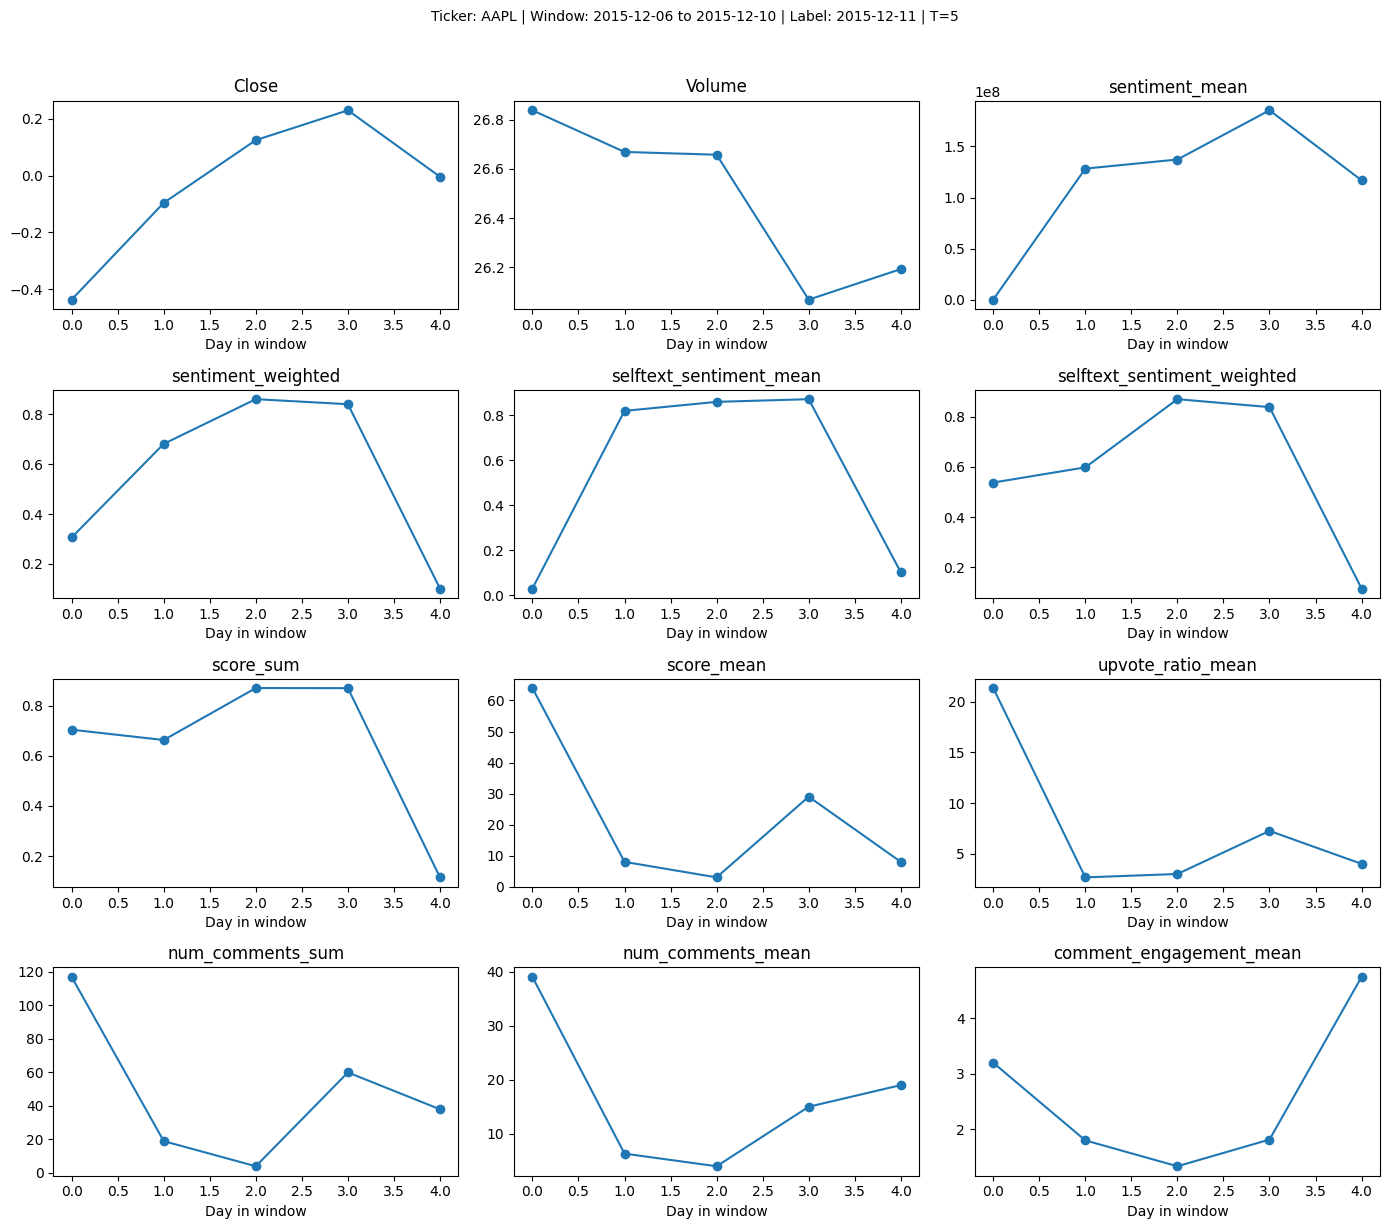

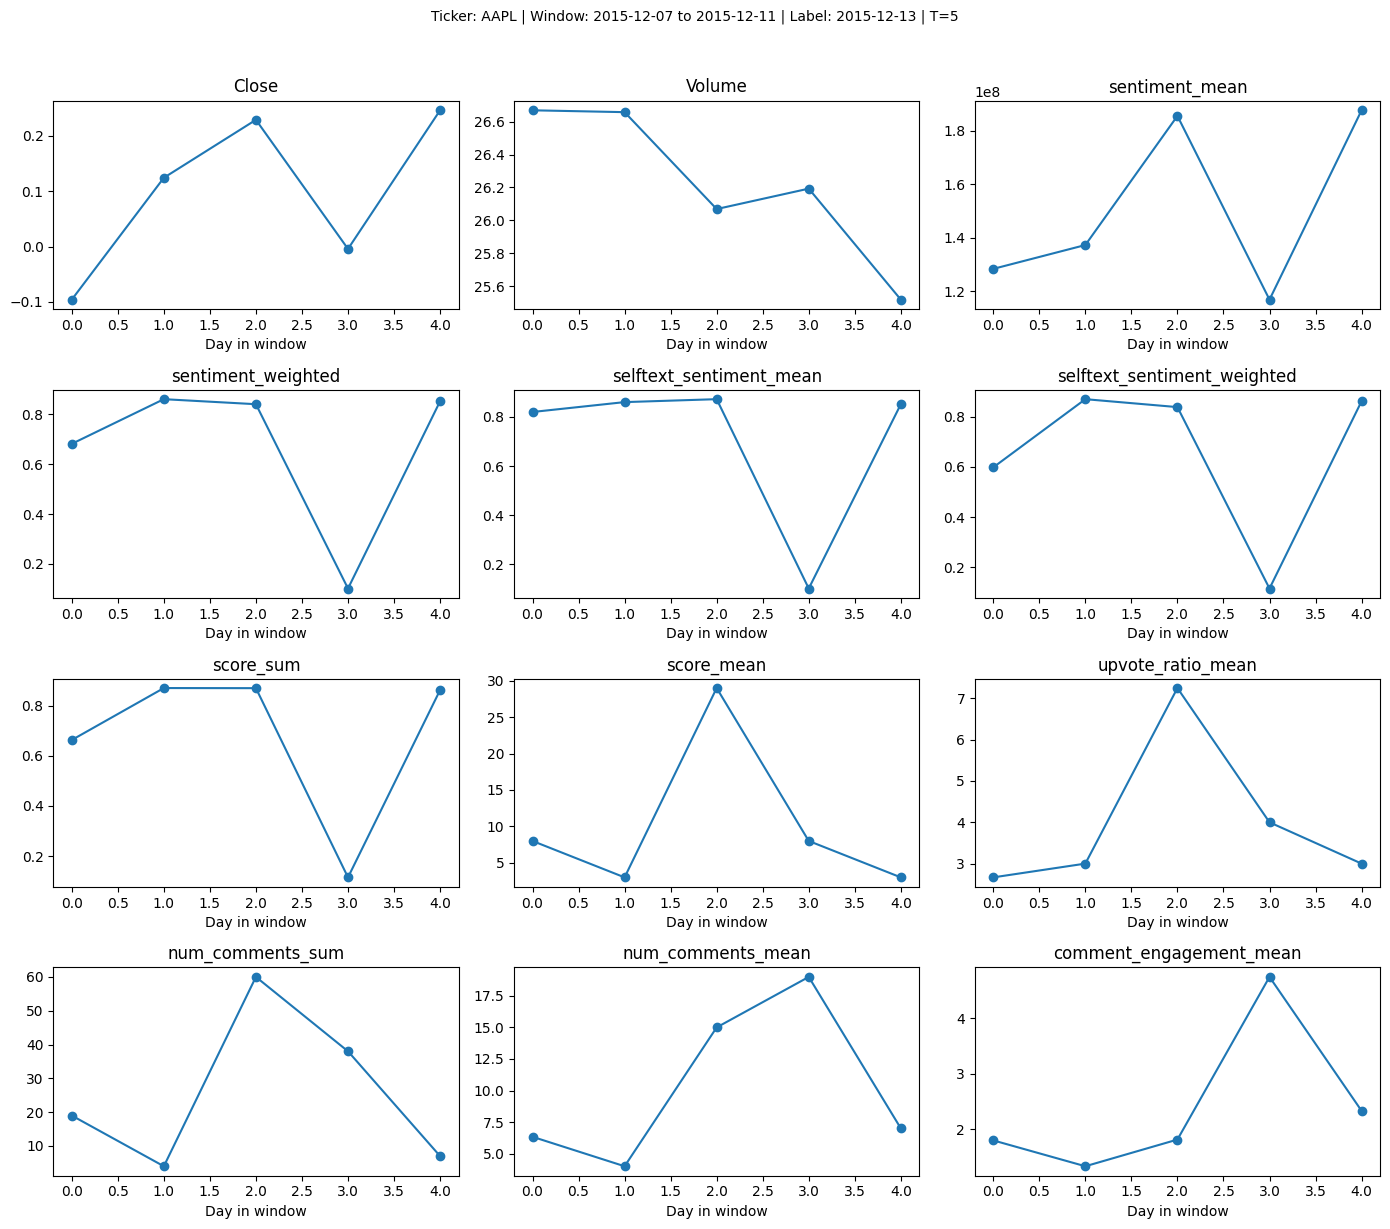

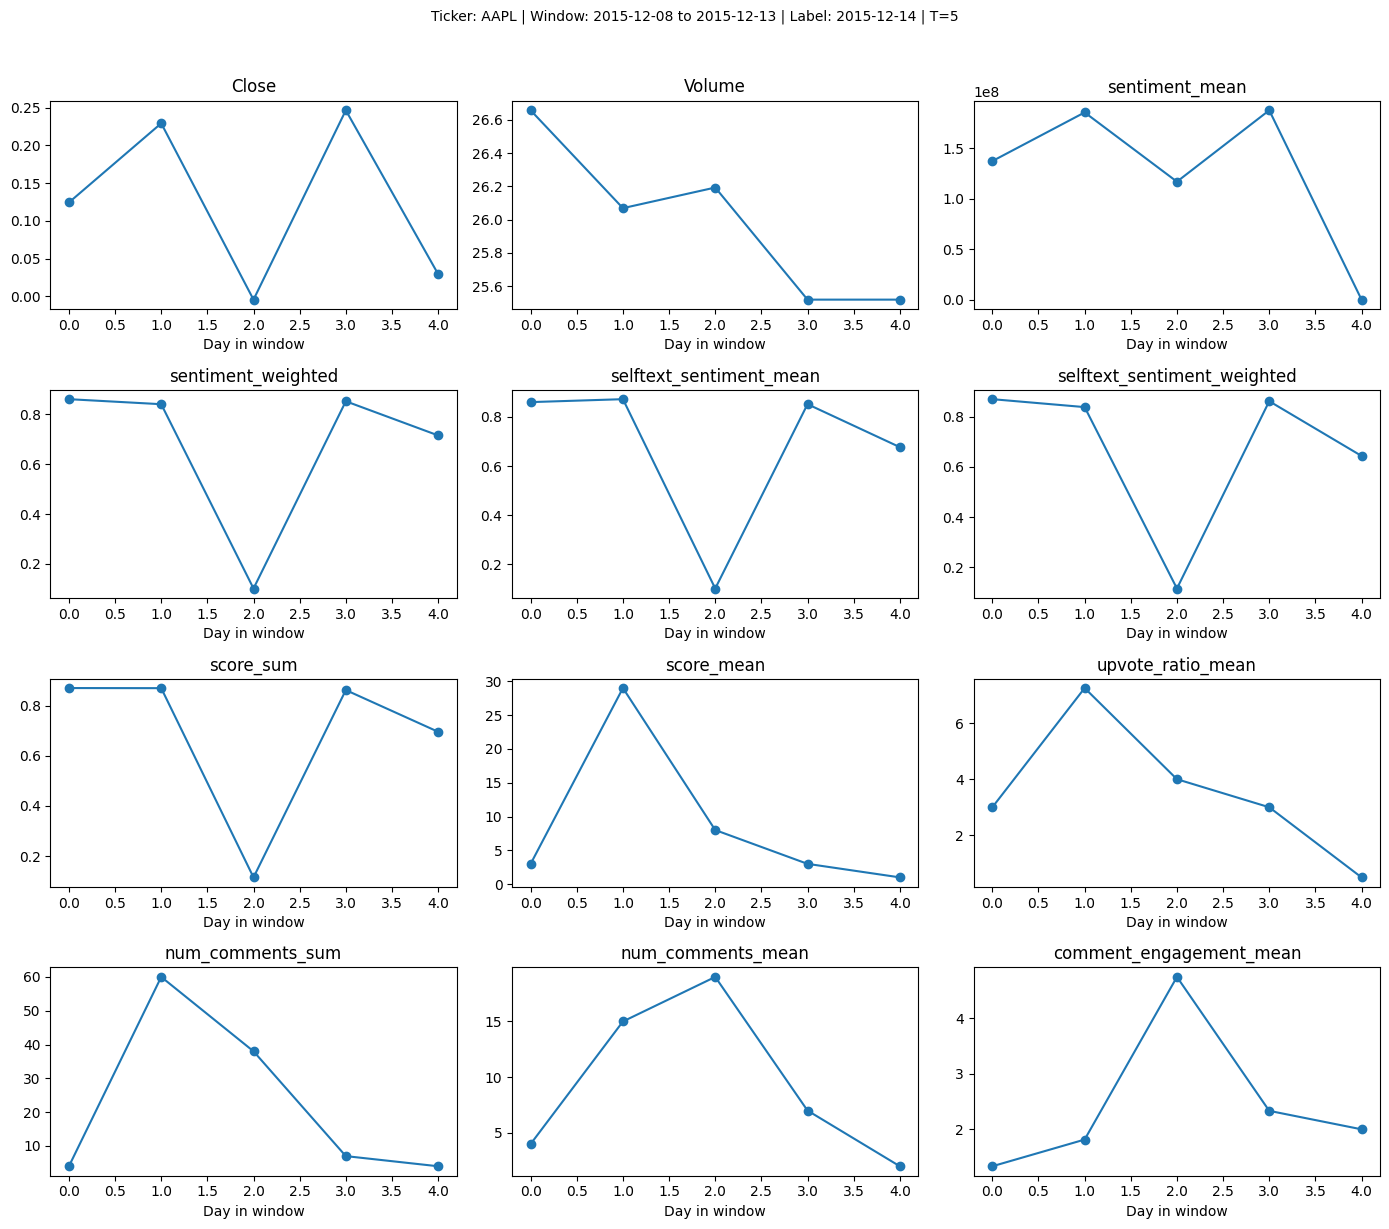

In [8]:
# Visualize a few sample sequences (numeric features over the window)
if len(globals().get('sequences', [])) == 0:
    print('No sequences to visualize. Run the previous cell to build sequences first.')
else:
    feature_names = [
        'Close', 'Volume', 'sentiment_mean', 'sentiment_weighted',
        'selftext_sentiment_mean', 'selftext_sentiment_weighted',
        'score_sum', 'score_mean', 'upvote_ratio_mean', 'num_comments_sum', 'num_comments_mean', 'comment_engagement_mean'
    ]
    num_feats = len(feature_names)
    D = int(sequences[0].shape[1])
    embed_dim = D - num_feats

    n_show = min(3, len(sequences))
    for k in range(n_show):
        seq = sequences[k].cpu().numpy()
        meta_k = meta[k] if k < len(meta) else {}
        tic = meta_k.get('ticker', 'NA')
        T = seq.shape[0]
        numeric = seq[:, embed_dim:]

        # Get dates from metadata
        window_start = meta_k.get('window_start_date', 'NA')
        window_end = meta_k.get('window_end_date', 'NA')
        label_date = meta_k.get('label_date', 'NA')

        cols = 3
        rows = int(math.ceil(num_feats / cols))
        fig, axes = plt.subplots(rows, cols, figsize=(14, 3*rows))
        axes = axes.flatten()
        for i, fname in enumerate(feature_names):
            ax = axes[i]
            ax.plot(range(T), numeric[:, i], marker='o')
            ax.set_title(fname)
            ax.set_xlabel('Day in window')
        for j in range(num_feats, len(axes)):
            axes[j].axis('off')
        fig.suptitle(f'Ticker: {tic} | Window: {window_start} to {window_end} | Label: {label_date} | T={T}', y=1.02, fontsize=10)
        plt.tight_layout()
        plt.show()

Total windows: 20355
Windows with at least one Reddit post on ANY day: 20355 (100.0%)
Windows with a Reddit post EVERY day: 17730 (87.1%)


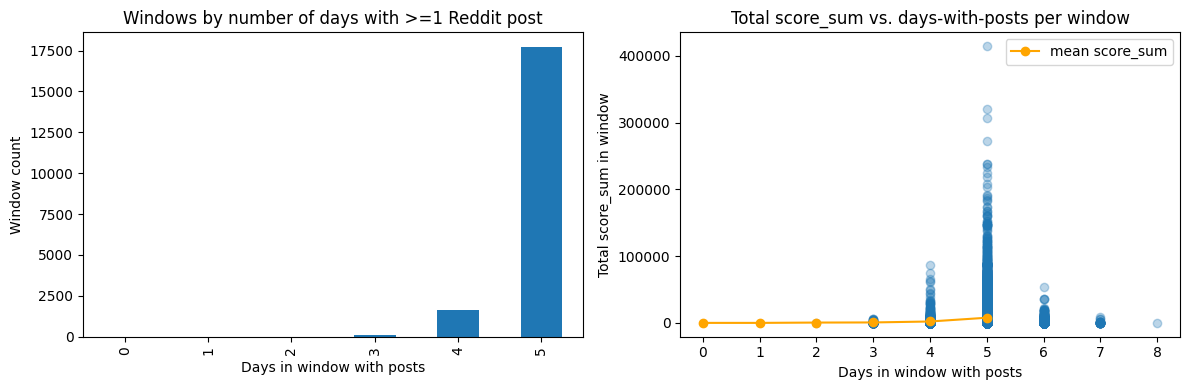

In [9]:
# Coverage of Reddit posts within built sequences + distributions
if len(globals().get('sequences', [])) == 0:
    print('No sequences built yet. Run the sequence-building cell first.')
else:
    rd = reddit.copy()
    rd['date'] = pd.to_datetime(rd['created_utc']).dt.tz_convert('US/Eastern').dt.date
    rd['ticker'] = rd['ticker'].astype(str).str.upper()
    # Use distinct names to avoid collisions with columns already in `merged`
    key_col = 'post_id' if 'post_id' in rd.columns else ('id' if 'id' in rd.columns else None)
    if key_col:
        post_counts = rd.groupby(['ticker','date'])[key_col].size().reset_index(name='posts')
    else:
        post_counts = rd.groupby(['ticker','date']).size().reset_index(name='posts')
    post_counts['score_sum_day'] = rd.groupby(['ticker','date'])['score'].sum().reset_index()['score']

    rows = []
    seq_len_local = int(lengths[0]) if len(lengths) else None
    for k, m in enumerate(meta):
        tic = m.get('ticker')
        T = int(sequences[k].shape[0])
        
        # Get window dates from metadata
        window_start = pd.to_datetime(m['window_start_date']).date()
        window_end = pd.to_datetime(m['window_end_date']).date()
        
        # Get trading calendar for this ticker
        if tic not in trading_calendar:
            continue
        ticker_cal = trading_calendar[tic]
        start_idx = ticker_cal.index(window_start) if window_start in ticker_cal else -1
        end_idx = ticker_cal.index(window_end) if window_end in ticker_cal else -1
        
        if start_idx == -1 or end_idx == -1:
            continue
        
        window_dates = ticker_cal[start_idx:end_idx+1]
        
        # Count posts in this window
        window_posts = post_counts[(post_counts['ticker'] == tic) & 
                                    (post_counts['date'].isin(window_dates))]
        days_with_post = int((window_posts['posts'] > 0).sum())
        total_posts = int(window_posts['posts'].sum())
        total_score = float(window_posts['score_sum_day'].sum())
        
        rows.append({
            'k': k,
            'ticker': tic,
            'T': T,
            'days_with_post': days_with_post,
            'has_any_day': days_with_post > 0,
            'has_all_days': days_with_post == T,
            'total_posts': total_posts,
            'total_score_sum': total_score,
        })

    cov = pd.DataFrame(rows)

    total_windows = len(cov)
    any_day = int(cov['has_any_day'].sum())
    all_days = int(cov['has_all_days'].sum())
    print(f'Total windows: {total_windows}')
    print(f'Windows with at least one Reddit post on ANY day: {any_day} ({any_day/max(total_windows,1):.1%})')
    print(f'Windows with a Reddit post EVERY day: {all_days} ({all_days/max(total_windows,1):.1%})')

    max_days = int(cov['T'].max()) if not cov.empty else (seq_len_local or 5)
    dist = cov['days_with_post'].value_counts().reindex(range(0, max_days+1), fill_value=0)
    mean_score_by_days = cov.groupby('days_with_post')['total_score_sum'].mean().reindex(range(0, max_days+1), fill_value=0)

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    dist.plot(kind='bar', ax=ax[0])
    ax[0].set_title('Windows by number of days with >=1 Reddit post')
    ax[0].set_xlabel('Days in window with posts')
    ax[0].set_ylabel('Window count')

    ax[1].scatter(cov['days_with_post'], cov['total_score_sum'], alpha=0.3)
    ax[1].plot(mean_score_by_days.index, mean_score_by_days.values, color='orange', marker='o', label='mean score_sum')
    ax[1].set_title('Total score_sum vs. days-with-posts per window')
    ax[1].set_xlabel('Days in window with posts')
    ax[1].set_ylabel('Total score_sum in window')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

In [10]:
from dataset import WeeklySentimentDataset, collate_weekly
from model import LSTMClassifier

# Build dataset
if len(sequences) == 0:
    print('No sequences built. Check your input coverage and date ranges.')
else:
    ds = WeeklySentimentDataset(
        sequences=sequences,
        lengths=lengths,
        direction=torch.tensor(labels_dir),
        magnitude=torch.tensor(labels_mag),
        metadata=meta,
    )
    batch = collate_weekly([ds[i] for i in range(min(8, len(ds)))], pad_to=5)

    input_dim = sequences[0].shape[1]
    model = LSTMClassifier(input_dim=input_dim).to(device)
    out = model(batch['x'].to(device), batch['lengths'].to(device))
    {k: tuple(v.shape) for k, v in out.items() if isinstance(v, torch.Tensor)}

Generating train/test/split of tesnors

In [11]:
# Compute confidence labels (trading-day coverage within each window)
print('Computing confidence labels based on trading-day coverage')

confidence_labels = []
if len(globals().get('sequences', [])) == 0:
    print('No sequences available. Build sequences first.')
else:
    # Build per-day post counts per ticker from Reddit
    rd = reddit.copy()
    rd['date'] = pd.to_datetime(rd['created_utc']).dt.tz_convert('US/Eastern').dt.date
    rd['ticker'] = rd['ticker'].astype(str).str.upper()
    key_col = 'post_id' if 'post_id' in rd.columns else ('id' if 'id' in rd.columns else None)
    if key_col:
        post_counts = rd.groupby(['ticker','date'])[key_col].size().reset_index(name='posts')
    else:
        post_counts = rd.groupby(['ticker','date']).size().reset_index(name='posts')
    pc_map = {(row['ticker'], row['date']): int(row['posts']) for _, row in post_counts.iterrows()}

    # For each window, check coverage across the trading days in that window
    for k, m in enumerate(meta):
        tic = m.get('ticker')
        T = int(sequences[k].shape[0])
        
        # Extract the window dates from metadata
        window_start = pd.to_datetime(m['window_start_date']).date()
        window_end = pd.to_datetime(m['window_end_date']).date()
        
        # Get trading calendar for this ticker and extract the window dates
        if tic not in trading_calendar:
            confidence_labels.append(1.0)
            continue
        
        ticker_cal = trading_calendar[tic]
        start_idx = ticker_cal.index(window_start) if window_start in ticker_cal else -1
        end_idx = ticker_cal.index(window_end) if window_end in ticker_cal else -1
        
        if start_idx == -1 or end_idx == -1:
            confidence_labels.append(1.0)
            continue
        
        window_dates = ticker_cal[start_idx:end_idx+1]
        
        if len(window_dates) == 0:
            confidence_labels.append(1.0)
            continue
        
        # Count how many days in the window have Reddit posts
        days_with_post = sum(1 for d in window_dates if pc_map.get((tic, d), 0) > 0)
        conf = float(days_with_post) / float(len(window_dates))
        confidence_labels.append(conf)

    if len(confidence_labels):
        print(f"Built {len(confidence_labels)} confidence labels.")
        print(f"  min={float(np.min(confidence_labels)):.2f}, max={float(np.max(confidence_labels)):.2f}, mean={float(np.mean(confidence_labels)):.2f}")
    else:
        print('No confidence labels built.')

Computing confidence labels based on trading-day coverage
Built 20355 confidence labels.
  min=0.18, max=1.00, mean=0.95
Built 20355 confidence labels.
  min=0.18, max=1.00, mean=0.95


In [12]:
# Create timestamped output directory
from datetime import datetime
import os

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
output_dir = os.path.join('tensors', f'run_{timestamp}')
os.makedirs(output_dir, exist_ok=True)

print(f"Output directory created: {output_dir}")
print(f"Timestamp: {timestamp}")

Output directory created: tensors/run_20251208_195349
Timestamp: 20251208_195349


In [13]:
# Train/Val/Test split (70/20/10) with proper scaling per split
import os, json
from sklearn.model_selection import train_test_split

print('Generating 70/20/10 train/val/test split with proper feature scaling')

if len(sequences) == 0:
    print('No sequences available. Run the preprocessing cells above first.')
else:
    rng_seed = 42
    desired_train, desired_val, desired_test = 0.70, 0.20, 0.10
    assert abs(desired_train + desired_val + desired_test - 1.0) < 1e-6, "Splits must sum to 1.0"

    indices = np.arange(len(sequences))

    train_val_idx, test_idx = train_test_split(indices, test_size=desired_test, random_state=rng_seed, shuffle=True)
    rel_val = desired_val / (1.0 - desired_test)
    train_idx, val_idx = train_test_split(train_val_idx, test_size=rel_val, random_state=rng_seed, shuffle=True)

    has_conf = len(globals().get('confidence_labels', [])) == len(sequences)

    # Determine embedding dimension
    embed_dim = sequences[0].shape[1] - 11  # 11 numeric features
    
    # Extract numeric features from training set to fit scaler
    print("\nFitting scaler on training data only (proper train/test separation)...")
    train_seqs = torch.stack([sequences[i] for i in train_idx], dim=0)
    train_numeric = train_seqs[:, :, embed_dim:].reshape(-1, 11).numpy()
    
    # Fit scaler on training data
    scaler = RobustScaler()
    scaler.fit(train_numeric)
    
    def scale_and_build_split(idxs, split_name):
        """Scale numeric features and build split data"""
        seqs_list = [sequences[i] for i in idxs]
        seqs_stacked = torch.stack(seqs_list, dim=0)  # [N, T, D]
        
        # Separate embeddings and numeric features
        embeds = seqs_stacked[:, :, :embed_dim]
        numerics = seqs_stacked[:, :, embed_dim:]
        
        # Scale numeric features using fitted scaler
        N, T, F = numerics.shape
        numerics_flat = numerics.reshape(-1, F).numpy()
        numerics_scaled = scaler.transform(numerics_flat)
        numerics_scaled = torch.tensor(numerics_scaled, dtype=torch.float32).reshape(N, T, F)
        
        # Combine back
        x = torch.cat([embeds, numerics_scaled], dim=-1)
        x = torch.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
        
        lengths_t = torch.tensor([int(lengths[i]) for i in idxs], dtype=torch.long)
        direction_t = torch.tensor([labels_dir[i] for i in idxs], dtype=torch.float32)
        magnitude_t = torch.tensor([labels_mag[i] for i in idxs], dtype=torch.float32)
        payload = {
            'x': x,
            'lengths': lengths_t,
            'direction': direction_t,
            'magnitude': magnitude_t,
            'meta': [meta[i] for i in idxs],
        }
        if has_conf:
            payload['confidence'] = torch.tensor([confidence_labels[i] for i in idxs], dtype=torch.float32)
        
        print(f"{split_name}: {len(idxs)} samples, features scaled using training scaler")
        return payload

    train_data = scale_and_build_split(train_idx, "Train")
    val_data = scale_and_build_split(val_idx, "Val")
    test_data = scale_and_build_split(test_idx, "Test")

    # Use timestamped output directory
    print(f"\nSaving to: {output_dir}")
    
    # Save scaler for future use
    import pickle
    with open(os.path.join(output_dir, 'scaler.pkl'), 'wb') as f:
        pickle.dump(scaler, f)
    print(f"Saved scaler to {os.path.join(output_dir, 'scaler.pkl')}")
    
    torch.save(train_data, os.path.join(output_dir, 'train.pt'))
    torch.save(val_data, os.path.join(output_dir, 'val.pt'))
    torch.save(test_data, os.path.join(output_dir, 'test.pt'))

    with open(os.path.join(output_dir, 'train_meta.json'), 'w') as f: json.dump(train_data['meta'], f)
    with open(os.path.join(output_dir, 'val_meta.json'), 'w') as f: json.dump(val_data['meta'], f)
    with open(os.path.join(output_dir, 'test_meta.json'), 'w') as f: json.dump(test_data['meta'], f)
    
    # Save run configuration
    config = {
        'timestamp': timestamp,
        'selected_stocks': SELECTED_STOCKS,
        'seq_len': seq_len,
        'label_offset': label_offset,
        'total_sequences': len(sequences),
        'train_size': len(train_idx),
        'val_size': len(val_idx),
        'test_size': len(test_idx),
        'embed_dim': embed_dim,
        'num_numeric_features': 11,
        'scaler_type': 'RobustScaler'
    }
    with open(os.path.join(output_dir, 'config.json'), 'w') as f:
        json.dump(config, f, indent=2)
    print(f"Saved configuration to {os.path.join(output_dir, 'config.json')}")

    def summarize(name, data):
        B, T, D = tuple(data['x'].shape)
        parts = [f"{name}: x={B}x{T}x{D}"]
        parts.append(f"lengths[min,max]=({int(data['lengths'].min())},{int(data['lengths'].max())})")
        if 'confidence' in data:
            parts.append(f"confidence[min,max]=({float(data['confidence'].min()):.2f},{float(data['confidence'].max()):.2f})")
        print(', '.join(parts))

    total = len(indices)
    pct = lambda n: 100.0 * n / max(total, 1)
    print(f"\nTotal samples: {total}")
    print(f"Train: {len(train_idx)} ({pct(len(train_idx)):.1f}%), Val: {len(val_idx)} ({pct(len(val_idx)):.1f}%), Test: {len(test_idx)} ({pct(len(test_idx)):.1f}%)")
    summarize('Train', train_data)
    summarize('Val', val_data)
    summarize('Test', test_data)
    print("\n✓ All numeric features scaled using RobustScaler fitted on training data")
    print(f"✓ Data saved to: {output_dir}")

Generating 70/20/10 train/val/test split with proper feature scaling

Fitting scaler on training data only (proper train/test separation)...
Train: 14248 samples, features scaled using training scaler
Val: 4071 samples, features scaled using training scaler
Test: 2036 samples, features scaled using training scaler

Saving to: tensors/run_20251208_195349
Saved scaler to tensors/run_20251208_195349/scaler.pkl
Train: 14248 samples, features scaled using training scaler
Val: 4071 samples, features scaled using training scaler
Test: 2036 samples, features scaled using training scaler

Saving to: tensors/run_20251208_195349
Saved scaler to tensors/run_20251208_195349/scaler.pkl
Saved configuration to tensors/run_20251208_195349/config.json

Total samples: 20355
Train: 14248 (70.0%), Val: 4071 (20.0%), Test: 2036 (10.0%)
Train: x=14248x5x779, lengths[min,max]=(5,5), confidence[min,max]=(0.18,1.00)
Val: x=4071x5x779, lengths[min,max]=(5,5), confidence[min,max]=(0.27,1.00)
Test: x=2036x5x779, l

In [51]:
# Save alternative split variant (different random seed)
import os, json, torch, pickle
from sklearn.model_selection import train_test_split
print('Saving alternative split to timestamped directory (70/20/10 split with different seed)')
if len(sequences)==0:
    print('No sequences; abort saving variant.')
else:
    rng_seed=123  # Different seed for alternative split
    desired_train, desired_val, desired_test = 0.70,0.20,0.10
    indices = np.arange(len(sequences))
    train_val_idx, test_idx = train_test_split(indices, test_size=desired_test, random_state=rng_seed, shuffle=True)
    rel_val = desired_val / (1.0 - desired_test)
    train_idx, val_idx = train_test_split(train_val_idx, test_size=rel_val, random_state=rng_seed, shuffle=True)
    has_conf = len(globals().get('confidence_labels', [])) == len(sequences)
    
    # Determine embedding dimension and fit scaler on training data
    embed_dim = sequences[0].shape[1] - 11
    print(f"\nFitting scaler on training data (embed_dim={embed_dim}, numeric_features=11)...")
    train_seqs = torch.stack([sequences[i] for i in train_idx], dim=0)
    train_numeric = train_seqs[:, :, embed_dim:].reshape(-1, 11).numpy()
    scaler = RobustScaler()
    scaler.fit(train_numeric)
    
    def build_split(idxs):
        seqs_list = [sequences[i] for i in idxs]
        seqs_stacked = torch.stack(seqs_list, dim=0)
        embeds = seqs_stacked[:, :, :embed_dim]
        numerics = seqs_stacked[:, :, embed_dim:]
        N, T, F = numerics.shape
        numerics_flat = numerics.reshape(-1, F).numpy()
        numerics_scaled = scaler.transform(numerics_flat)
        numerics_scaled = torch.tensor(numerics_scaled, dtype=torch.float32).reshape(N, T, F)
        x = torch.cat([embeds, numerics_scaled], dim=-1)
        x = torch.nan_to_num(x, nan=0.0)
        lengths_t = torch.tensor([int(lengths[i]) for i in idxs], dtype=torch.long)
        direction_t = torch.tensor([labels_dir[i] for i in idxs], dtype=torch.float32)
        magnitude_t = torch.tensor([labels_mag[i] for i in idxs], dtype=torch.float32)
        payload = {'x':x,'lengths':lengths_t,'direction':direction_t,'magnitude':magnitude_t,'meta':[meta[i] for i in idxs]}
        if has_conf:
            payload['confidence']=torch.tensor([confidence_labels[i] for i in idxs], dtype=torch.float32)
        return payload
    
    train_data = build_split(train_idx)
    val_data = build_split(val_idx)
    test_data = build_split(test_idx)
    
    # Create alternative subdirectory in the timestamped folder
    alt_dir = os.path.join(output_dir, 'alternative_split')
    os.makedirs(alt_dir, exist_ok=True)
    
    # Save scaler
    with open(os.path.join(alt_dir, 'scaler.pkl'), 'wb') as f:
        pickle.dump(scaler, f)
    
    torch.save(train_data, os.path.join(alt_dir,'train.pt'))
    torch.save(val_data, os.path.join(alt_dir,'val.pt'))
    torch.save(test_data, os.path.join(alt_dir,'test.pt'))
    for split_name, data_obj in [('train',train_data),('val',val_data),('test',test_data)]:
        with open(os.path.join(alt_dir,f'{split_name}_meta.json'),'w') as f: json.dump(data_obj['meta'], f)
    
    # Save alternative configuration
    alt_config = {
        'timestamp': timestamp,
        'selected_stocks': SELECTED_STOCKS,
        'seq_len': seq_len,
        'label_offset': label_offset,
        'random_seed': rng_seed,
        'total_sequences': len(sequences),
        'train_size': len(train_idx),
        'val_size': len(val_idx),
        'test_size': len(test_idx),
        'note': 'Alternative split with different random seed'
    }
    with open(os.path.join(alt_dir, 'config.json'), 'w') as f:
        json.dump(alt_config, f, indent=2)
    
    def summarize(name,data):
        B,T,D = data['x'].shape
        msg = f"{name}: x={B}x{T}x{D}, lengths[min,max]=({int(data['lengths'].min())},{int(data['lengths'].max())})"
        if 'confidence' in data:
            msg += f", confidence[min,max]=({float(data['confidence'].min()):.2f},{float(data['confidence'].max()):.2f})"
        print(msg)
    total=len(indices); pct=lambda n:100.0*n/max(total,1)
    print(f'Total samples: {total} | Train {len(train_idx)} ({pct(len(train_idx)):.1f}%) | Val {len(val_idx)} ({pct(len(val_idx)):.1f}%) | Test {len(test_idx)} ({pct(len(test_idx)):.1f}%)')
    summarize('train',train_data); summarize('val',val_data); summarize('test',test_data)
    print(f"\n✓ Saved alternative split with RobustScaler to {alt_dir}")

Saving alternative split to timestamped directory (70/20/10 split with different seed)

Fitting scaler on training data (embed_dim=768, numeric_features=11)...
Total samples: 20343 | Train 14239 (70.0%) | Val 4069 (20.0%) | Test 2035 (10.0%)
train: x=14239x5x779, lengths[min,max]=(5,5), confidence[min,max]=(0.19,1.00)
val: x=4069x5x779, lengths[min,max]=(5,5), confidence[min,max]=(0.18,1.00)
test: x=2035x5x779, lengths[min,max]=(5,5), confidence[min,max]=(0.31,1.00)

✓ Saved alternative split with RobustScaler to tensors/run_20251201_200424/alternative_split


In [16]:
# Inspect saved data in timestamped output directory
import os, torch
print(f'Inspecting output directory: {output_dir}')
print('='*60)
for split in ['train','val','test']:
    p = os.path.join(output_dir, f'{split}.pt')
    if not os.path.exists(p):
        print(f'Missing {p}')
        continue
    payload = torch.load(p, map_location='cpu')
    keys = sorted(payload.keys())
    print(f'\n[{split}] keys={keys}')
    x = payload['x']; lens = payload['lengths']
    print(f'  x {tuple(x.shape)}, lengths {tuple(lens.shape)}')
    for k in ['direction','magnitude','confidence']:
        if k in payload:
            t = payload[k]
            rng = f"{float(t.min()):.3f}..{float(t.max()):.3f}" if t.ndim==1 else ''
            print(f'  {k}: {tuple(t.shape)} {rng}')

# Check if config and scaler exist
if os.path.exists(os.path.join(output_dir, 'config.json')):
    with open(os.path.join(output_dir, 'config.json'), 'r') as f:
        config = json.load(f)
    print(f'\n✓ Configuration saved:')
    for key, value in config.items():
        print(f'  {key}: {value}')

if os.path.exists(os.path.join(output_dir, 'scaler.pkl')):
    print(f'\n✓ Scaler saved: {os.path.join(output_dir, "scaler.pkl")}')

print(f'\n✓ All data ready in: {output_dir}')

Inspecting output directory: tensors/run_20251208_195349

[train] keys=['confidence', 'direction', 'lengths', 'magnitude', 'meta', 'x']
  x (14248, 5, 779), lengths (14248,)
  direction: (14248,) 0.000..1.000
  magnitude: (14248,) 0.000..0.298
  confidence: (14248,) 0.182..1.000

[val] keys=['confidence', 'direction', 'lengths', 'magnitude', 'meta', 'x']
  x (4071, 5, 779), lengths (4071,)
  direction: (4071,) 0.000..1.000
  magnitude: (4071,) 0.000..0.172
  confidence: (4071,) 0.267..1.000

[test] keys=['confidence', 'direction', 'lengths', 'magnitude', 'meta', 'x']
  x (2036, 5, 779), lengths (2036,)
  direction: (2036,) 0.000..1.000
  magnitude: (2036,) 0.000..0.178
  confidence: (2036,) 0.211..1.000

✓ Configuration saved:
  timestamp: 20251208_195349
  selected_stocks: None
  seq_len: 5
  label_offset: 1
  total_sequences: 20355
  train_size: 14248
  val_size: 4071
  test_size: 2036
  embed_dim: 768
  num_numeric_features: 11
  scaler_type: RobustScaler

✓ Scaler saved: tensors/ru

In [15]:
# Inspect saved tensor files: list keys and shapes to confirm model readiness
import os, torch, json

def tensor_shape(t):
    return tuple(t.shape) if hasattr(t, 'shape') else None

for split in ['train', 'val', 'test']:
    p = os.path.join('tensors', f'{split}.pt')
    if not os.path.exists(p):
        print(f'{split}.pt not found at {p}')
        continue
    payload = torch.load(p, map_location='cpu')
    keys = sorted(list(payload.keys()))
    print(f'[{split}] keys: {keys}')
    x = payload.get('x'); lens = payload.get('lengths')
    y_dir = payload.get('direction'); y_mag = payload.get('magnitude')
    conf = payload.get('confidence', None)
    print(f'  x: {tensor_shape(x)}, lengths: {tensor_shape(lens)}, direction: {tensor_shape(y_dir)}, magnitude: {tensor_shape(y_mag)}')
    if conf is not None:
        print(f'  confidence: {tensor_shape(conf)} (range {float(conf.min()):.2f}..{float(conf.max()):.2f})')
    meta = payload.get('meta', [])
    print(f'  meta entries: {len(meta)}')

# Ready for model if x is [B,T,D] and lengths is [B]
print('If x is [B,T,D] and lengths is [B], these are ready to pass to LSTMClassifier.')

[train] keys: ['confidence', 'direction', 'lengths', 'magnitude', 'meta', 'x']
  x: (934, 5, 778), lengths: (934,), direction: (934,), magnitude: (934,)
  confidence: (934,) (range 0.00..1.00)
  meta entries: 934
[val] keys: ['confidence', 'direction', 'lengths', 'magnitude', 'meta', 'x']
  x: (268, 5, 778), lengths: (268,), direction: (268,), magnitude: (268,)
  confidence: (268,) (range 0.20..1.00)
  meta entries: 268
[test] keys: ['confidence', 'direction', 'lengths', 'magnitude', 'meta', 'x']
  x: (134, 5, 778), lengths: (134,), direction: (134,), magnitude: (134,)
  confidence: (134,) (range 0.20..1.00)
  meta entries: 134
If x is [B,T,D] and lengths is [B], these are ready to pass to LSTMClassifier.


# Summary of Changes

This notebook has been updated with the following improvements:

## 1. **Stock Selection Configuration** ✓
- Added configuration section at the top to select specific stocks
- Set `SELECTED_STOCKS = None` to process all stocks
- Set `SELECTED_STOCKS = ['AAPL', 'GOOGL', ...]` to process only specific tickers
- Filtering applied to both Reddit and Yahoo Finance data

## 2. **Updated Schema Processing** ✓
- Fixed Reddit data loading to match actual CSV structure (columns: timestamp, id, created_utc, author, title, selftext, score, num_comments, stock, subreddit, source, query)
- Fixed Yahoo Finance data processing to handle the transposed wide format where first row contains ticker symbols
- Properly restructured YF data from wide format to long format (date, ticker, Close, Volume)

## 3. **Window Creation Logic**
- **Reverted to original method**: Windows are built by iterating through sorted merged data
- Each window contains consecutive days from the sorted data
- Simple date-based windowing (no trading calendar iteration)

## 4. **Feature Scaling with scikit-learn** ✓
- Added `StandardScaler` and `RobustScaler` from scikit-learn
- **RobustScaler used** for numeric features (better for financial data with outliers)
- **FinBERT embeddings unchanged** (already normalized)
- **Proper train/test separation**: Scaler fitted on training data only, then applied to val/test
- **11 numeric features scaled**: Close, Volume, sentiment_mean, sentiment_weighted, selftext_sentiment_mean, selftext_sentiment_weighted, score_sum, score_mean, num_comments_sum, num_comments_mean, comment_engagement_mean
- **Scaler saved** alongside tensors for future inference

## 5. **Timestamped Output Directories** ✓
- Each run creates a new timestamped folder: `tensors/run_YYYYMMDD_HHMMSS/`
- Preserves all previous runs automatically
- No overwriting of old data
- Configuration saved with each run for reproducibility
- Alternative splits saved in subdirectories

## 6. **Data Quality**
- NaN handling improved with `torch.nan_to_num`
- Robust to missing data in sequences
- Proper date parsing for both Reddit and YF data

## 7. **Output Structure**
Each timestamped folder contains:
- `train.pt`, `val.pt`, `test.pt`: Tensor data files
- `train_meta.json`, `val_meta.json`, `test_meta.json`: Metadata
- `scaler.pkl`: Fitted RobustScaler for inference
- `config.json`: Complete run configuration (stocks, parameters, sizes, timestamp)
- `alternative_split/`: Optional alternative split with different random seed

All tensor files include:
- `x`: Scaled features [B, T, D] where embeddings are unchanged and numeric features are scaled
- `lengths`: Sequence lengths [B]
- `direction`: Binary labels (up/down) [B]
- `magnitude`: Absolute return magnitude [B]
- `confidence`: Coverage metric based on Reddit post availability [B] (optional)
- `meta`: Metadata with ticker, window dates, label date

# Verify Label Offset

Check that the labels are indeed one day ahead of the window end date.

In [17]:
# Verify that labels are exactly 1 day after the window end date
import os, torch, json
from datetime import datetime, timedelta

print("="*70)
print("VERIFYING LABEL OFFSET: Checking that labels are 1 day ahead")
print("="*70)

# Check config first
if os.path.exists(os.path.join(output_dir, 'config.json')):
    with open(os.path.join(output_dir, 'config.json'), 'r') as f:
        config = json.load(f)
    print(f"\n✓ Config file shows label_offset: {config.get('label_offset')}")
else:
    print("\n⚠ Config file not found")

# Load test metadata to verify actual dates
test_meta_path = os.path.join(output_dir, 'test_meta.json')
if os.path.exists(test_meta_path):
    with open(test_meta_path, 'r') as f:
        test_meta = json.load(f)
    
    print(f"\n✓ Loaded {len(test_meta)} test samples")
    print("\nChecking first 10 samples:")
    print("-" * 70)
    
    mismatches = []
    for i, sample in enumerate(test_meta[:10]):
        window_end = datetime.strptime(sample['window_end_date'], '%Y-%m-%d').date()
        label_date = datetime.strptime(sample['label_date'], '%Y-%m-%d').date()
        
        # Calculate the difference
        diff = (label_date - window_end).days
        
        ticker = sample['ticker']
        status = "✓" if diff == 1 else "✗"
        
        print(f"{status} Sample {i+1} [{ticker}]:")
        print(f"   Window End:  {window_end}")
        print(f"   Label Date:  {label_date}")
        print(f"   Difference:  {diff} day(s)")
        
        if diff != 1:
            mismatches.append((i, ticker, window_end, label_date, diff))
    
    # Check all samples for mismatches
    print("\n" + "="*70)
    print("Checking ALL samples...")
    all_mismatches = []
    day_differences = []
    
    for i, sample in enumerate(test_meta):
        window_end = datetime.strptime(sample['window_end_date'], '%Y-%m-%d').date()
        label_date = datetime.strptime(sample['label_date'], '%Y-%m-%d').date()
        diff = (label_date - window_end).days
        day_differences.append(diff)
        
        if diff != 1:
            all_mismatches.append((i, sample['ticker'], window_end, label_date, diff))
    
    # Summary statistics
    print(f"\nTotal samples checked: {len(test_meta)}")
    print(f"Samples with 1-day offset: {day_differences.count(1)}")
    print(f"Samples with other offsets: {len(all_mismatches)}")
    
    if len(all_mismatches) == 0:
        print("\n" + "="*70)
        print("✅ SUCCESS: All labels are exactly 1 day ahead of window end!")
        print("="*70)
    else:
        print(f"\n⚠ WARNING: Found {len(all_mismatches)} samples with incorrect offset:")
        for idx, ticker, w_end, l_date, diff in all_mismatches[:5]:
            print(f"  Sample {idx} [{ticker}]: {w_end} → {l_date} ({diff} days)")
        if len(all_mismatches) > 5:
            print(f"  ... and {len(all_mismatches) - 5} more")
    
    # Show distribution of offsets if there are variations
    from collections import Counter
    offset_distribution = Counter(day_differences)
    print(f"\nOffset distribution:")
    for offset, count in sorted(offset_distribution.items()):
        pct = 100 * count / len(day_differences)
        print(f"  {offset} day(s): {count} samples ({pct:.1f}%)")
else:
    print(f"\n⚠ Test metadata file not found at {test_meta_path}")

print("\n" + "="*70)

VERIFYING LABEL OFFSET: Checking that labels are 1 day ahead

✓ Config file shows label_offset: 1

✓ Loaded 2036 test samples

Checking first 10 samples:
----------------------------------------------------------------------
✓ Sample 1 [GOOGL]:
   Window End:  2019-09-14
   Label Date:  2019-09-15
   Difference:  1 day(s)
✓ Sample 2 [AMZN]:
   Window End:  2025-02-13
   Label Date:  2025-02-14
   Difference:  1 day(s)
✓ Sample 3 [AAPL]:
   Window End:  2025-11-20
   Label Date:  2025-11-21
   Difference:  1 day(s)
✓ Sample 4 [GOOGL]:
   Window End:  2018-01-21
   Label Date:  2018-01-22
   Difference:  1 day(s)
✓ Sample 5 [TSLA]:
   Window End:  2025-09-11
   Label Date:  2025-09-12
   Difference:  1 day(s)
✓ Sample 6 [TSLA]:
   Window End:  2017-02-06
   Label Date:  2017-02-07
   Difference:  1 day(s)
✓ Sample 7 [TSLA]:
   Window End:  2024-03-06
   Label Date:  2024-03-07
   Difference:  1 day(s)
✓ Sample 8 [GOOGL]:
   Window End:  2020-09-24
   Label Date:  2020-09-25
   Difference